In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
import sys
import os

# Add project root (one level above notebooks) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.features import add_lags_and_rolls, add_calendar
from utils.preprocessing import load_and_prepare

from statsmodels.tsa.statespace.sarimax import SARIMAX

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

In [10]:
df_daily = load_and_prepare('../data/uk_power_demand.csv',
                        date_col='SETTLEMENT_DATE',
                        value_col='ENGLAND_WALES_DEMAND',
                        freq='D')

target = df_daily.columns[0]

In [17]:
# Splitting the data into "training" (past) and "validation" (future)


train, test = train_test_split(df_daily[target], test_size=0.2, shuffle=False)

# Define the SARIMA model

sarima = SARIMAX(
    endog=train,          # the demand series we want to predict
    order=(1,1,1),                # (p,d,q): handles short-term patterns + trend
    seasonal_order=(1,1,1,7),     # (P,D,Q,s): handles weekly seasonality (7 days)
    enforce_stationarity=False,   # don’t force strict mathematical rules
    enforce_invertibility=False   # same idea: more flexibility for learning
)

# p = how many past values to look at
# d = how many times to subtract previous values to remove trends
# q = how much it should use past forecast errors to improve itself

# Train (fit) the model on the training data

sarima_fit = sarima.fit(disp=False) #.fit() means: learn patterns from the training period

# Forecast into the validation period

sarima_forecast = sarima_fit.predict(
    start=valid.index[0],  # first date of the validation set
    end=valid.index[-1]    # last date of the validation set
)

# Measure how good the forecast is

sarima_mae = mean_absolute_error(valid[target], sarima_forecast)
print(f"SARIMA MAE: {sarima_mae} MW")

SARIMA MAE: 43135.095319615444 MW


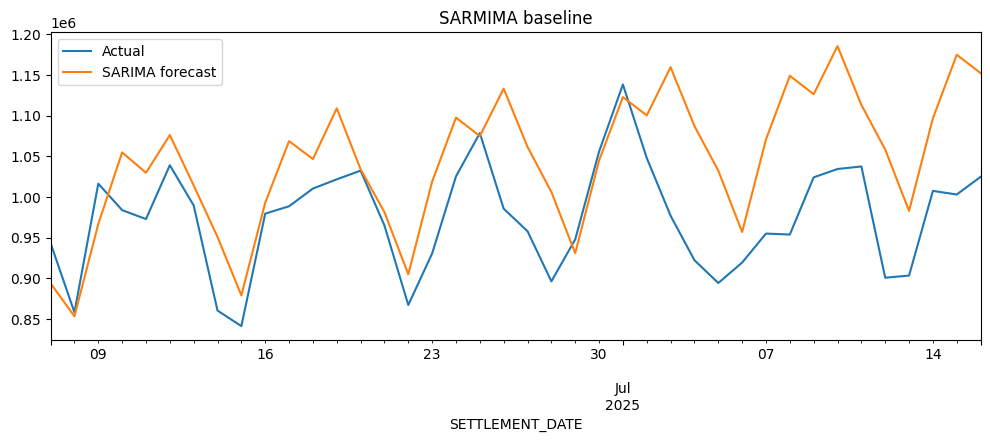

In [14]:
ax = valid[target].plot(figsize=(12,4), label='Actual')   #plot real
sarima_forecast.plot(ax=ax, label='SARIMA forecast')      #plot predicted
plt.legend()
plt.title('SARMIMA baseline')
plt.show()

In [34]:
df_feat = add_calendar(add_lags_and_rolls(df_daily.copy(), target, lags=(1,7,14), rolls=(3,7,14))).dropna()

X = df_feat.drop(columns=[target])
y = df_feat[target]

# Time-aware split: no shuffling

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = y.loc[X_train.index], y.loc[X_test.index]

# Define and train the model

xgb = XGBRegressor(
    n_estimators=500,      # number of trees
    learning_rate=0.05,    # step size shrinkage, slower but more precise, how much should each guess be changed
    max_depth=6,           # tree depth (complexity control)
    subsample=0.9,         # row sampling for robustness, prevents overfitting. like only looks at .9 days
    colsample_bytree=0.9,  # feature sampling for robustness, only looks at .9 features
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)  # train model on training data

# Predict on the test slice
xgb_pred = pd.Series(xgb.predict(X_test), index=y_test.index)


In [35]:
# Align validation targets for the two models (indexes may differ if your feature DF drops early rows)
y_valid_common = y_test.reindex(index=test.index.intersection(sarima_forecast.index))
sarima_forecast = sarima_forecast.reindex(y_valid_common.index)

y_valid_ml = y_test.reindex(index=y_test.index.intersection(xgb_pred.index))
xgb_pred = xgb_pred.reindex(y_valid_ml.index)

In [36]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def mape(y_true, y_pred, eps=1e-9):
    # MAPE% = mean(|(y - yhat)/y|)*100; guard against zeros
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [39]:
rows = []

rows.append({
    "Model": "SARIMA(1,1,1)(1,1,1,7)",
    "MAE": mean_absolute_error(y_valid_common, sarima_forecast),
    "RMSE": rmse(y_valid_common, sarima_forecast),
    "MAPE%": mape(y_valid_common, sarima_forecast)
})

rows.append({
    "Model": "XGBoost (lags, rolls, calendar)",
    "MAE": mean_absolute_error(y_valid_ml, xgb_pred),
    "RMSE": rmse(y_valid_ml, xgb_pred),
    "MAPE%": mape(y_valid_ml, xgb_pred)
})

metrics_df = pd.DataFrame(rows).set_index("Model").round(2)
metrics_df


TypeError: got an unexpected keyword argument 'squared'